** Zhiyu Fu **

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Q1

In [2]:
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut
import seaborn as sb
from sklearn.model_selection import KFold
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
sd = pd.read_csv("data/strongdrink.txt")
xvar = ["alco", "malic", "tot_phen", "color_int"]
yvar = ["cultivar"]
X_train, X_test, y_train, y_test = \
    train_test_split(sd[xvar], sd[yvar], test_size = 0.25,
       random_state=20)
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg.fit(X_train, y_train)
coef = pd.DataFrame(MultLogReg.coef_[0:2], index = ["cultivar = 1", "cultivar = 2"], columns = xvar)
coef.loc[:,"Intercept"] = MultLogReg.intercept_[:2]
coef

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,alco,malic,tot_phen,color_int,Intercept
cultivar = 1,1.700368,-0.265602,1.223892,0.022762,-24.010548
cultivar = 2,-1.468065,-0.333055,0.664017,-0.922714,22.802713


In [4]:
pd.crosstab(index = y_test["cultivar"], columns = 'count')

col_0,count
cultivar,
1,13
2,21
3,10


In [5]:
print(classification_report(y_test, MultLogReg.predict(X_test)))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



Cat 2 and 3 both achieve perfect precision, but according to other scores category 3 is best at predicting, which, on the contrary to the question, has fewest observations.

## b) LOOCV

In [6]:
N = sd.shape[0]
loo = LeaveOneOut()
Xvars = sd[xvar].values
yvals = sd[yvar].values
loo.get_n_splits(Xvars)
classify = np.empty((N, 2))
for train_index, test_index in loo.split(sd[xvar]):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index],yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    classify[test_index,:] = np.array([y_test, y_pred]).reshape((1,2))

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
print(classification_report(classify[:,0], classify[:,1]))

             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



The precision rates for each category is in the first column.
The precision is worse than that from part (a) in general, except for cat 1 the first method achieves better precision.

In [8]:
print("The average MSE is:")
(1 - (classify[:,0] == classify[:,1])).mean()

The average MSE is:


0.079545454545454544

## c) k-fold cross validation

In [9]:
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)
classify_kf = np.empty((N, 2))
k_ind = 0
for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    classify_kf[test_index,0:1] = y_test
    classify_kf[test_index,1] = y_pred

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
print(classification_report(classify_kf[:,0], classify_kf[:,1]))

             precision    recall  f1-score   support

        1.0       0.87      0.93      0.90        59
        2.0       0.91      0.87      0.89        71
        3.0       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176



The precision rates for each category is in the first column.
The precision is worse than that from part (a) and part (b) on average.

In [11]:
print("The average MSE is:")
(1 - (classify_kf[:,0] == classify_kf[:,1])).mean()

The average MSE is:


0.090909090909090912

# Q2

## Scatterplot

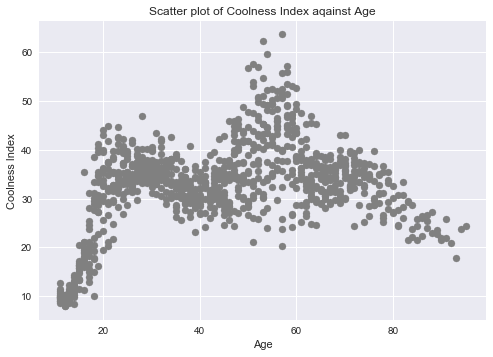

In [12]:
ci = pd.read_csv("data/CoolIndex.txt",  names = ['age', "CI"], header = None, dtype = {0:np.int32, 1:np.float64})
ci.head()
fig, ax = plt.subplots()
ax.scatter(ci['age'], ci['CI'], c = "gray")
ax.set_xlabel("Age")
ax.set_ylabel("Coolness Index")
ax.set_title("Scatter plot of Coolness Index aqainst Age")
fig

## Stepwise Function

In [13]:
cutoff = np.array([21, 39, 58, 76])
ci.loc[:,"binnum"] = np.searchsorted(cutoff, ci.age)
ci = pd.concat((ci, 
    pd.get_dummies(ci.binnum, prefix = "bin")),
    axis = 1)

In [14]:
reg = sm.OLS(ci.CI, ci.iloc[:,-5:]).fit()

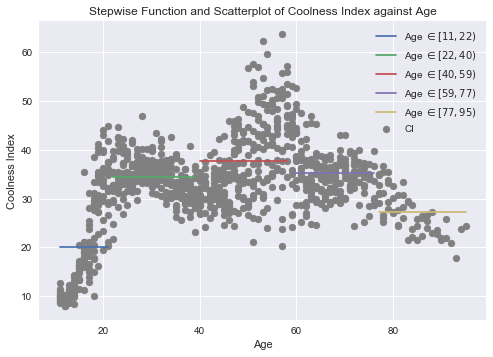

In [15]:
bins = [
    "$\in [11, 22)$",
    "$\in [22, 40)$",
    "$\in [40, 59)$",
    "$\in [59, 77)$",
    "$\in [77, 95)$"
]
for i in range(5):
    ax.plot(ci.loc[ci.binnum == i, "age"], np.ones((ci.binnum == i).sum()) * reg.params[i], 
            label = 'Age ' + bins[i])
ax.set_title("Stepwise Function and Scatterplot of Coolness Index against Age")
ax.legend()
fig

In [16]:
print("beta 0 to beta 5 are as follows:")
reg.params

beta 0 to beta 5 are as follows:


bin_0    20.102457
bin_1    34.475788
bin_2    37.635105
bin_3    35.225400
bin_4    27.296378
dtype: float64

In [17]:
print("Predicted coolness of a 73-year old is")
reg.params[np.searchsorted(cutoff, 73)]

Predicted coolness of a 73-year old is


35.225400040242754

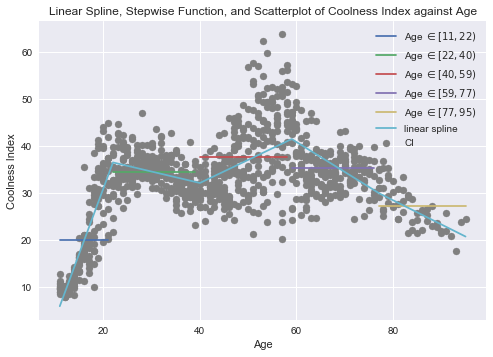

In [18]:
knots = [22, 40, 59, 77]
spl_ci = LSQUnivariateSpline(ci.age.values, ci.CI.values, knots, k=1)
age_vec = np.linspace(ci.age.values.min(), ci.age.values.max(), 1000)
ax.plot(age_vec, spl_ci(age_vec), label = "linear spline")
ax.legend()
ax.set_title("Linear Spline, Stepwise Function, and Scatterplot of Coolness Index against Age")

fig

In [19]:
print("Predicted coolness of a 73-year old from linear spline is")
spl_ci(73)

Predicted coolness of a 73-year old from linear spline is


array(32.536832389143306)

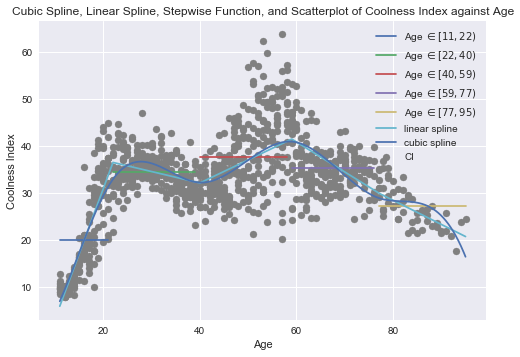

In [20]:
cubspl_ci = LSQUnivariateSpline(ci.age.values, ci.CI.values, knots, k=3)
age_vec = np.linspace(ci.age.values.min(), ci.age.values.max(), 1000)
ax.plot(age_vec, cubspl_ci(age_vec), label = "cubic spline")
ax.legend()
ax.set_title("Cubic Spline, Linear Spline, Stepwise Function, and Scatterplot of Coolness Index against Age")

fig

In [21]:
print("Predicted coolness of a 73-year old from cubic spline is")
cubspl_ci(73)

Predicted coolness of a 73-year old from cubic spline is


array(31.262429389257864)